In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import IPython.display as ipd
# % pylab inline
import os
import pandas as pd
import librosa
import glob 
import librosa.display
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.utils.np_utils import to_categorical

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam  # "from keras.optimizers import Adam" don't work so i have to import it like "from tensorflow.keras.optimizers import Adam"
from keras.utils import np_utils
from sklearn import metrics 

from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout 
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

from keras.callbacks import EarlyStopping

from keras import regularizers

from sklearn.preprocessing import LabelEncoder

from datetime import datetime

import os

In [4]:
#list the files
filelist = os.listdir('drive/MyDrive/interview_cracker/male') 
#read them into pandas
df_male = pd.DataFrame(filelist)

In [5]:
# Adding the 1 label to the dataframe representing male
df_male['label']='1'


In [6]:
# Renaming the column name to file
df_male = df_male.rename(columns={0:'file'})

In [7]:
df_male.head()

,file,label
0,8842-302201-0004.flac,1
1,8842-302201-0009.flac,1
2,8842-302201-0007.flac,1
3,8842-302196-0009.flac,1
4,8842-302196-0005.flac,1


In [8]:

# Checking for a file that gets automatically generated and we need to drop 
df_male[df_male['file']=='.DS_Store']

,file,label


**Doing same thing for female folder**

In [9]:
filelist1 = os.listdir('drive/MyDrive/interview_cracker/female') 
#read them into pandas
df_female = pd.DataFrame(filelist1)

In [10]:
df_female['label']='0'

In [11]:
df_female = df_female.rename(columns={0:'file'})

In [12]:
df_female.head()


,file,label
0,8297-275156-0007.flac,0
1,8297-275156-0001.flac,0
2,8297-275156-0002.flac,0
3,8297-275156-0013.flac,0
4,8297-275156-0008.flac,0


In [13]:
# Checking for a file that gets automatically generated and we need to drop 
df_female[df_female['file']=='.DS_Store']

,file,label


**Now concate both folder**

In [14]:

df = pd.concat([df_female, df_male], ignore_index=True)

In [15]:
df.head()

,file,label
0,8297-275156-0007.flac,0
1,8297-275156-0001.flac,0
2,8297-275156-0002.flac,0
3,8297-275156-0013.flac,0
4,8297-275156-0008.flac,0


**Dividing approx 70% file as train, approx 20% for validation and 10% for test**

In [16]:
df_train = df[:95]

In [17]:
df_train['label'].value_counts(normalize=True)

1    0.724638
0    0.275362
Name: label, dtype: float64

In [18]:
df_validation = df[95:122]

In [19]:
df_validation['label'].value_counts(normalize=True)

Series([], Name: label, dtype: float64)

In [20]:
df_test = df[122:]

In [21]:
df_test['label'].value_counts(normalize=True)

Series([], Name: label, dtype: float64)

**Function to extract the features and label for each sound file by iterating through every row of the dataframe**

In [22]:
df.size

138

In [23]:
# Although this function was modified and many parameteres were explored with, most of it
# came from Source 8 (sources in the READ.ME)

def extract_features(files):
    
    # Sets the name to be the path to where the file is in my computer
    file_name = os.path.join(os.path.abspath('drive/MyDrive/interview_cracker/whole')+'/'+str(files.file))

    # Loads the audio file as a floating point time series and assigns the default sample rate
    # Sample rate is set to 22050 by default
    X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

    # Generate Mel-frequency cepstral coefficients (MFCCs) from a time series 
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)

    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
        
    
    # We add also the classes of each file as a label at the end
    label = files.label

    return mfccs, chroma, mel, contrast, tonnetz, label

In [24]:
# Code to start the timer to see how long it takes to extract the features
startTime = datetime.now()

In [25]:

# Applying the function to the train data by accessing each row of the dataframe
features_label = df.apply(extract_features, axis=1)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=853
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=597
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=765
  n_fft, y.shape[-1]
/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=931
  n_fft, y.shape[-1]


In [26]:
# Code to see how long it took
print(datetime.now() - startTime)

0:01:26.895094


In [27]:
# Checking how the output looks
features_label

0     ([-334.05945, 109.49289, -28.287344, 47.812187...
1     ([-345.315, 107.45816, -17.925451, 36.806644, ...
2     ([-340.062, 108.6981, -16.715584, 40.13201, -1...
3     ([-325.4779, 130.2642, -19.76352, 40.792877, -...
4     ([-360.77695, 126.58335, -11.7097, 33.6185, -1...
                            ...                        
64    ([-353.22678, 110.91761, -45.825043, 29.917164...
65    ([-402.26685, 111.84585, -37.14864, 20.815756,...
66    ([-342.57373, 121.6945, -43.526638, 32.307713,...
67    ([-424.49646, 104.72611, -30.974213, 21.364588...
68    ([-406.85092, 94.36623, -41.766384, 29.625416,...
Length: 69, dtype: object

In [28]:
# We create an empty list where we will concatenate all the features into one long feature
# for each file to feed into our neural network 

features = []
for i in range(0, len(features_label)):
    features.append(np.concatenate((features_label[i][0], features_label[i][1], 
                features_label[i][2], features_label[i][3],
                features_label[i][4]), axis=0))

In [29]:
len(features)

69

**We will add the speaker id to our dataframe to have that as the label for our model and predict speakers from their voice**

In [30]:
# We create an empty list where we will append all the speakers ids for each row of our
# dataframe by slicing the file name since we know the id is the first numbers before the hash
speaker = []
for i in range(0, len(df)):
    speaker.append(df['file'][i].split('-')[0])

In [31]:
# Now we create the speaker column in our dataframe and set it equal to our speaker list
df['speaker'] = speaker

In [32]:

# Checking that it worked as expected
df.head()

,file,label,speaker
0,8297-275156-0007.flac,0,8297
1,8297-275156-0001.flac,0,8297
2,8297-275156-0002.flac,0,8297
3,8297-275156-0013.flac,0,8297
4,8297-275156-0008.flac,0,8297


In [33]:
# Checking the number of speakers or the number of different people in our voice data
df['speaker'].nunique()

2

In [34]:
# Setting our labels to be equal to our speaker list
labels = speaker

In [35]:
# Checking the size of labels and making sure it matches the size of features
len(labels)

69

**Checking if we have balanced classes for the whole data**

In [36]:
# They look somewhat balanced with a min of 56 and a max of 166, mean of 114 
# with standard deviation of 15.89 (calculated from scipy)
np.unique(labels, return_counts=True)

(array(['8297', '8842'], dtype='<U4'), array([14, 55]))

**Hot encoding y and pre processing X and y**

In [37]:
X = np.array(features)

In [38]:
y = np.array(labels)

In [39]:

# Hot encoding y
lb = LabelEncoder()
y = to_categorical(lb.fit_transform(y))

In [40]:
X.shape

(69, 193)

In [41]:
y.shape

(69, 2)

In [42]:

# Choosing the first 9188 (70%) files to be our train data
# Choosing the next  2625 (20%) files to be our validation data
# Choosing the next  1312 (10%) files to be our test never before seen data
# This is analogous to a train test split but we add a validation split and we are making
# we do not shuffle anything since we are dealing with several time series, we already 
# checked before that we have balanced classes (analogous to stratify)

X_train = X[:48]
y_train = y[:48]

X_val = X[48:]
y_val = y[48:]


In [43]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)

In [44]:
# Build a simple dense model with early stopping with softmax for categorical classification
# We have 115 classes 

model = Sequential()

model.add(Dense(193, input_shape=(193,), activation = 'relu'))
model.add(Dropout(0.1))

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.25))  

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))    

model.add(Dense(2, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, mode='auto')

In [45]:

# fitting the model with the train data and validation with the validation data
# we used early stop with patience 100 because we did not want to use early stop
# I leave the early stop regularization code in case anyone wants to use it

history = model.fit(X_train, y_train, batch_size=256, epochs=100, 
                    validation_data=(X_val, y_val),
                    callbacks=[early_stop])

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.8547 - accuracy: 0.4375 - val_loss: 0.6219 - val_accuracy: 0.6667
Epoch 2/100
1/1 [==============================] - 0s 26ms/step - loss: 0.6422 - accuracy: 0.6042 - val_loss: 0.4570 - val_accuracy: 0.9524
Epoch 3/100
1/1 [==============================] - 0s 28ms/step - loss: 0.4076 - accuracy: 0.8333 - val_loss: 0.3404 - val_accuracy: 1.0000
Epoch 4/100
1/1 [==============================] - 0s 27ms/step - loss: 0.2832 - accuracy: 0.8958 - val_loss: 0.2584 - val_accuracy: 1.0000
Epoch 5/100
1/1 [==============================] - 0s 44ms/step - loss: 0.2511 - accuracy: 0.9167 - val_loss: 0.1978 - val_accuracy: 1.0000
Epoch 6/100
1/1 [==============================] - 0s 39ms/step - loss: 0.1416 - accuracy: 0.9792 - val_loss: 0.1512 - val_accuracy: 1.0000
Epoch 7/100
1/1 [==============================] - 0s 33ms/step - loss: 0.1529 - accuracy: 0.9792 - val_loss: 0.1173 - val_accuracy: 1.0000
Epoch 8/100
1/1 [=====

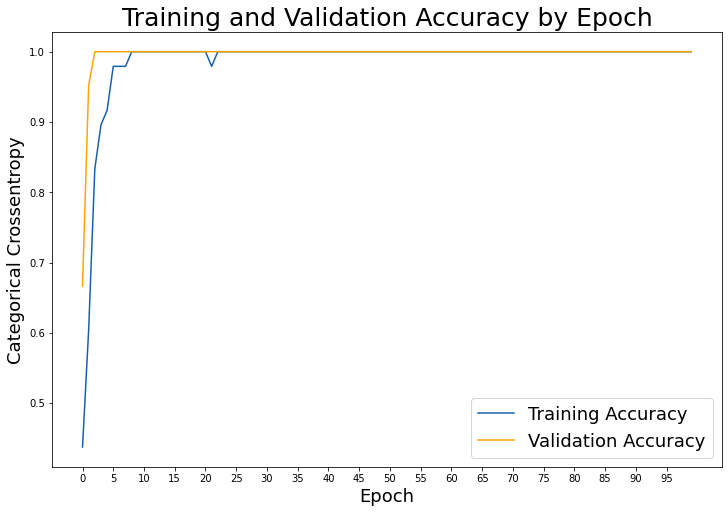

In [46]:
# Check out our train accuracy and validation accuracy over epochs.
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Set figure size.
plt.figure(figsize=(12, 8))

# Generate line plot of training, testing loss over epochs.
plt.plot(train_accuracy, label='Training Accuracy', color='#185fad')
plt.plot(val_accuracy, label='Validation Accuracy', color='orange')

# Set title
plt.title('Training and Validation Accuracy by Epoch', fontsize = 25)
plt.xlabel('Epoch', fontsize = 18)
plt.ylabel('Categorical Crossentropy', fontsize = 18)
plt.xticks(range(0,100,5), range(0,100,5))

plt.legend(fontsize = 18);